In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch
import kornia as K
from tqdm import tqdm

# img = plt.imread('bowl-of-fruit.jpg')
# t_rgb: torch.tensor = K.image_to_tensor(img)
# t_rgb = t_rgb.unsqueeze(0)
# img_rgb: np.array = K.tensor_to_image(t_rgb)
# plt.imshow(img_rgb)

### 1. Canny edge detection Q1

In [2]:
def MyCanny(img, sigma, t_ratio):
    #convert image to tensors
    t_rgb: torch.tensor = K.image_to_tensor(img)
    t_rgb = t_rgb.unsqueeze(0)
    img_rgb: np.array = K.tensor_to_image(t_rgb)
    #get the grayscale tensor
    t_g = K.color.rgb_to_grayscale(t_rgb.float())
    img_g: np.array = K.tensor_to_image(t_g)
    #implement guassian blur
    t_blur = K.filters.gaussian_blur2d(t_g, (3, 3), (sigma, sigma))
    img_blur: np.array = K.tensor_to_image(t_blur)
    #take the first derivative with respect to x, y, and flip the kernel
    sobel_x = torch.tensor([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]])
    sobel_xf = sobel_x.expand(1, 1, 3, 3)
    sobel_y = torch.tensor([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]])
    sobel_yf = sobel_y.expand(1, 1, 3, 3)
    #Do convolution with the sobel filters
    x_conv = torch.conv2d(t_blur.float(), sobel_xf)
    img_convx: np.array = K.tensor_to_image(x_conv)
    y_conv = torch.conv2d(t_blur.float(), sobel_yf)
    img_convy: np.array = K.tensor_to_image(y_conv)
    #get the gradient magnitude
    t_mag = torch.sqrt(torch.pow(x_conv, 2) + torch.pow(y_conv, 2))
    img_mag: np.array = K.tensor_to_image(t_mag)
    #calculate the orientation of magnitude
    t_ori = torch.atan2(y_conv, x_conv)
    img_ori: np.array = K.tensor_to_image(t_ori)
        
    width = img_mag.shape[0]
    length = img_mag.shape[1]
    img_sup = np.zeros((width, length), dtype = np.float32)

    theta = img_ori
    theta[img_ori < 0] += np.pi

    #divdes into six regions
    for w in range(1, width - 1):
        for l in range(1, length - 1):
            nei_1 = 0 #neighbor 1
            nei_2 = 0 #neighbor 2
            
            if(0 <= theta[w, l] and theta[w, l] < (np.pi/8)):
                nei_1 = img_mag[w, l + 1]
                nei_2 = img_mag[w, l - 1]
            elif((np.pi / 8) <= theta[w, l] and theta[w, l] < (3 * np.pi / 8)):
                nei_1 = img_mag[w + 1, l - 1]
                nei_2 = img_mag[w - 1, l + 1]
            elif((3 * np.pi / 8) <= theta[w, l] and theta[w, l] < (4 * np.pi / 8)):
                nei_1 = img_mag[w + 1, l]
                nei_2 = img_mag[w - 1, l]
            elif((4 * np.pi / 8) <= theta[w, l] and theta[w, l] < (5 * np.pi / 8)):
                nei_1 = img_mag[w - 1, l - 1]
                nei_2 = img_mag[w + 1, l + 1]
            elif((5 * np.pi / 8) <= theta[w, l] and theta[w, l] < (np.pi)):
                nei_1 = img_mag[w, l + 1]
                nei_2 = img_mag[w, l - 1]
            if(img_mag[w, l] >= nei_1) and (img_mag[w, l] >= nei_2):
                img_sup[w, l] = img_mag[w, l]
            else:
                img_sup[w, l] = 0
    ratio_t = t_ratio #threshold ratio
    threshold = ratio_t * np.amax(img_mag)
    output = np.zeros((width, length))
    #assign intencity to the signal entry
    output[img_sup > threshold] = 1
    return output

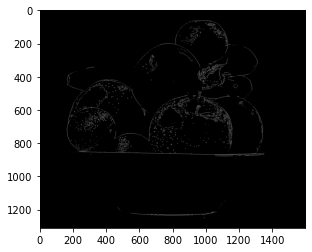

In [3]:
img = plt.imread('bowl-of-fruit.jpg')
sigma = 5.
t_ratio = 0.1 
img_temp = MyCanny(img, sigma, t_ratio) 
# input parameters: image matrix, standard deviation for gaussian blur(float), threshold ratio 
plt.imshow(img_temp, cmap = 'gray')
plt.imsave('myCanny.jpg', img_temp, cmap = 'gray')

In [4]:
def MyCannyFull(img, sigma, h_ratio, l_ratio):
    #mostly the same from MyCanny
    t_rgb: torch.tensor = K.image_to_tensor(img)
    t_rgb = t_rgb.unsqueeze(0)
    img_rgb: np.array = K.tensor_to_image(t_rgb)
    t_g = K.color.rgb_to_grayscale(t_rgb.float())
    img_g: np.array = K.tensor_to_image(t_g)
    t_blur = K.filters.gaussian_blur2d(t_g, (3, 3), (sigma, sigma))
    img_blur: np.array = K.tensor_to_image(t_blur)
    sobel_x = torch.tensor([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]])
    sobel_xf = sobel_x.expand(1, 1, 3, 3)
    sobel_y = torch.tensor([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]])
    sobel_yf = sobel_y.expand(1, 1, 3, 3)
    x_conv = torch.conv2d(t_blur.float(), sobel_xf)
    img_convx: np.array = K.tensor_to_image(x_conv)
    y_conv = torch.conv2d(t_blur.float(), sobel_yf)
    img_convy: np.array = K.tensor_to_image(y_conv)
    t_mag = torch.sqrt(torch.pow(x_conv, 2) + torch.pow(y_conv, 2))
    img_mag: np.array = K.tensor_to_image(t_mag)
    t_ori = torch.atan2(y_conv, x_conv)
    img_ori: np.array = K.tensor_to_image(t_ori)
    width = img_mag.shape[0]
    length = img_mag.shape[1]
    img_sup = np.zeros((width, length), dtype = np.float32)

    theta = img_ori
    theta[img_ori < 0] += np.pi

    #divdes into eight directions
    for w in range(1, width - 1):
        for l in range(1, length - 1):
            nei_1 = 0
            nei_2 = 0
        
            if(0 <= theta[w, l] and theta[w, l] < (np.pi/8)):
                nei_1 = img_mag[w, l + 1]
                nei_2 = img_mag[w, l - 1]
            elif((np.pi/8) <= theta[w, l] and theta[w, l] < (3*np.pi/8)):
                nei_1 = img_mag[w + 1, l - 1]
                nei_2 = img_mag[w - 1, l + 1]
            elif((3*np.pi/8) <= theta[w, l] and theta[w, l] < (4*np.pi/8)):
                nei_1 = img_mag[w + 1, l]
                nei_2 = img_mag[w - 1, l]
            elif((4*np.pi/8) <= theta[w, l] and theta[w, l] < (5*np.pi/8)):
                nei_1 = img_mag[w - 1, l - 1]
                nei_2 = img_mag[w + 1, l + 1]
            elif((5*np.pi/8) <= theta[w, l] and theta[w, l] < (np.pi)):
                nei_1 = img_mag[w, l + 1]
                nei_2 = img_mag[w, l - 1]
            if(img_mag[w, l] >= nei_1) and (img_mag[w, l] >= nei_2):
                img_sup[w, l] = img_mag[w, l]
            else:
                img_sup[w, l] = 0
                
    output = np.zeros((width, length))
    ratio_l = l_ratio #threshold ratio
    threshold_l = ratio_l * np.amax(img_mag)
    #assign intencity to the signal entry
    output[img_sup > threshold_l] = 1 #high intensity
    
    ratio_h = h_ratio #threshold ratio
    threshold_h = ratio_h * np.amax(img_mag)
    #assign intencity to the signal entry
    output[img_sup > threshold_h] = 2 #high intensity
    
    linked = np.zeros((w, l))
        
    for w in range(0, width - 1):
        for l in range(0, length - 1):
            output, linked = check(output, w, l, linked)   
    return output

In [5]:
def check(output, w, l, linked):
    if(output[w, l] == 2 and linked[w, l] == 0):
        nei = np.array([[w + 1, l + 1], [w - 1, l + 1], [w + 1, l - 1], 
               [w - 1, l - 1], [w, l + 1], [w + 1, l], [w - 1, l], [w, l - 1]])
        linked[w, l] = 1
        for i in range(0, 8):
            if output[nei[i][0], nei[i][1]] == 1:
                output[nei[i][0], nei[i][1]] = 2
                check(output, nei[i][0], nei[i][1], linked)
            else:
                output[w, l] = 0
    return output, linked
    

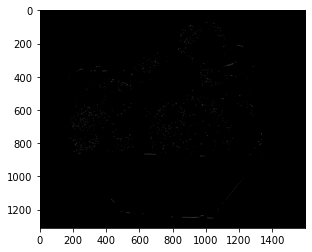

In [6]:
img = plt.imread('bowl-of-fruit.jpg')
sigma = 5.
h_ratio = 0.1
l_ratio = 0.08
img_temp = MyCannyFull(img, sigma, h_ratio, l_ratio) 
# input parameters: image matrix, standard deviation for gaussian blur(float), threshold ratio 
plt.imshow(img_temp, cmap = 'gray')

In [7]:
# plt.imsave('myCannyFull.jpg', img_temp, cmap = 'gray')

### Seam Carving

In [8]:
img = plt.imread('York.jpg') #input of York image

In [66]:
def CarvingHelper(img, flag):
    t_rgb: torch.tensor = K.image_to_tensor(img)
    t_rgb = t_rgb.unsqueeze(0)
    img_rgb: np.array = K.tensor_to_image(t_rgb)
    plt.imshow(img_rgb)
    t_grad: torch.tensor = K.filters.spatial_gradient(t_rgb.float(), order = 1)
    t_grad_x = t_grad[:, :, 0, :]
    t_grad_y = t_grad[:, :, 1, :]
    t_grad_x = torch.pow(t_grad_x, 2)
    t_grad_y = torch.pow(t_grad_y, 2)
    t_energy = torch.sqrt(t_grad_x + t_grad_y)
    t_energy = torch.sum(t_energy, dim = 1)
    energy: np.array = K.tensor_to_image(t_energy)
    M = energy.copy()
    row_num = img.shape[0]
    col_num = img.shape[1]
    #dynamic programming
    for r in range(1, row_num):
        for c in range(0, col_num):
            if c == 0: #at the left edge of image
                M[r, c] = energy[r, c] + min(M[r - 1, c], M[r - 1, c + 1])
            elif c == col_num - 1: #at the right edge of image
                M[r, c] = energy[r, c] + min(M[r - 1, c - 1], M[r - 1, c])
            else:
                M[r, c] = energy[r, c] + min(M[r - 1, c - 1], M[r - 1, c], M[r - 1, c + 1])

    #create the shortest path of minimum energy sum
    path = []
    #find the index of the minimum sum of energy in the last row
    col_min = np.argmin(M[row_num - 1])
    path.append(col_min)
    #backtracking from bottom row to top row
    for r in range(1, row_num):
        col_min = path[-1] # the minimum energy of the previous row
        if col_min == 0: # edge case
            #find next minimum
            mins = min(M[row_num - r][col_min], M[row_num - r][col_min + 1])
            #keep track of the index and avoiding taking the duplicates as next min
            if mins == M[row_num - r][col_min + 1]: 
                path.append(col_min + 1)
            elif mins == M[row_num - r][col_min]:
                path.append(col_min)
        elif(col_min == col_num - 1): # edge case
            mins = min(M[row_num - r][col_min], M[row_num - r][col_min - 1])
            #keep track of the index and avoiding taking the duplicates as next min
            if mins == M[row_num - r][col_min]:
                path.append(col_min)
            elif mins == M[row_num - r][col_min - 1]:
                path.append(col_min - 1)
        else:
            mins = min(M[row_num - r][col_min], M[row_num - r][col_min + 1],  M[row_num - r][col_min - 1])
            #keep track of the index and avoiding taking the duplicates as next min
            if mins == M[row_num - r][col_min]:
                path.append(col_min)
            elif mins == M[row_num - r][col_min - 1]:
                path.append(col_min - 1)
            elif mins == M[row_num - r][col_min + 1]:
                path.append(col_min + 1)
#     print(img.shape) #used for track the progress of seam carving
    path = path[::-1]
    if(flag == 1):
        row_num = img.shape[0]
        col_num = img.shape[1]
        img_pt = np.zeros((row_num, col_num), dtype = np.float64)
        for r in range(0, row_num):
            img_pt[r, path[r]] = - 1.
        img_pt = np.array([img_pt, img_pt, img_pt])
        img_pt = np.stack(img_pt, axis = 2)
        result = img[img_pt != -1].reshape((row_num, col_num - 1, 3))
    else:
        result = np.zeros((row_num, col_num + 1, 3), dtype = np.float64)
        for row in range(0, row_num):
            seam = path[row]
            for c in range(0, 3): 
                if(seam == 0):
                    avg = np.mean(img[row, 0: 2, c])
                    result[row, 1, c] = img[row, 0, c]
                    result[row, 0, c] = avg
#                     result[row, 1, c] = img[row, 0, c]
                    result[row, 2 : col_num + 1, c] = img[row, 1 : col_num, c]
                else:
                    avg = np.mean(img[row, seam - 1 : seam + 1, c])
                    result[row, : seam, c] = img[row, : seam, c]
                    result[row, seam, c] = avg
                    result[row, seam + 1 : col_num + 1, c] = img[row, seam : col_num, c]
    return result



In [53]:
# def MySeamCarving(img, new_width, new_height):
#     #remove seam vertically
#     while(img.shape[1] > new_height):
#         img = CarvingHelper(img, 1)
#     #remove seam horizontally
#     if(img.shape[0] > new_width):
#         img = np.transpose(img, (1, 0, 2))
#         while(img.shape[1] > new_width):
#             img = CarvingHelper(img, 1)
#         img = np.transpose(img, (1, 0, 2))
#     #insert seam vertically
#     while(img.shape[1] < new_height):
#         img = CarvingHelper(img, 0)
#     #insert seam horizontally
#     if(img.shape[0] < new_width):
#         img = np.transpose(img, (1, 0, 2))
#         while(img.shape[1] < new_width):
#             img = CarvingHelper(img, 0)
#         img = np.transpose(img, (1, 0, 2))
#     return img.astype(np.uint8)
        
    

In [21]:
def MySeamCarving(img, new_width, new_height):
    #remove seam vertically
    if(img.shape[1] > new_height):
        for i in tqdm(range(img.shape[1] - new_height)):
            img = CarvingHelper(img, 1)
    #remove seam horizontally
    if(img.shape[0] > new_width):
        img = np.transpose(img, (1, 0, 2))
#         while(img.shape[1] > new_width):
        for i in tqdm(range(img.shape[1] - new_width)):
            img = CarvingHelper(img, 1)
        img = np.transpose(img, (1, 0, 2))
    #insert seam vertically
#     while(img.shape[1] < new_height):
    if(img.shape[1] < new_height):
        for i in tqdm(range(new_height - img.shape[1])):
            img = CarvingHelper(img, 0)
    #insert seam horizontally
    if(img.shape[0] < new_width):
        img = np.transpose(img, (1, 0, 2))
#         while(img.shape[1] < new_width):
    if(img.shape[1] < new_width):
        for i in tqdm(range(new_width - img.shape[1])):
            img = CarvingHelper(img, 0)
        img = np.transpose(img, (1, 0, 2))
    return img.astype(np.uint8)
        
    

100%|█████████████████████████████████████████████| 8/8 [00:19<00:00,  2.46s/it]


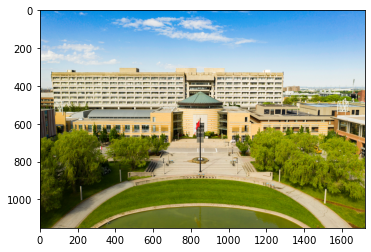

In [41]:
#Running for the resized image 1151*1200
img_v = MySeamCarving(img.copy(), 1151, 1720)
plt.imshow(img_v.astype(int))
plt.imsave('img_v.jpg', img_v)


100%|███████████████████████████████████████████| 12/12 [00:32<00:00,  2.70s/it]


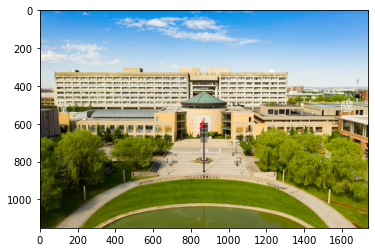

In [67]:
#Running for the resized image 1151*1200
img_n = MySeamCarving(img.copy(), 1151, 1740)
plt.imshow(img_n.astype(int))
plt.imsave('img_n.jpg', img_n)

100%|███████████████████████████████████████████| 21/21 [00:56<00:00,  2.71s/it]


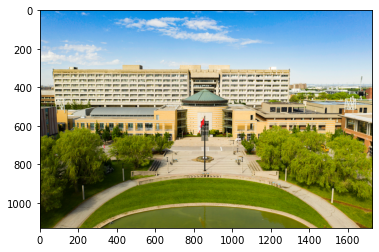

In [68]:
#Running for the resized image 1728*720
img_h = MySeamCarving(img.copy(), 1130, 1728)
plt.imshow(img_h.astype(int))
plt.imsave('img_h.jpg', img_h)

(1210, 2048, 3)


100%|███████████████████████████████████████████| 10/10 [00:29<00:00,  2.92s/it]


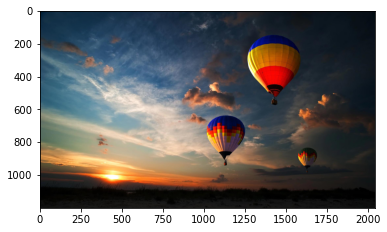

In [29]:
#Running for the resized my own image from 2048*1210 to 2040*1200
img_my = plt.imread('my_original.jpg')
print(img_my.shape)
img_v_my = MySeamCarving(img_my.copy(), 1200, 2040)
plt.imshow(img_v_my.astype(int))
plt.imsave('img_v_my.jpg',img_v_my)

100%|███████████████████████████████████████████| 10/10 [00:41<00:00,  4.11s/it]


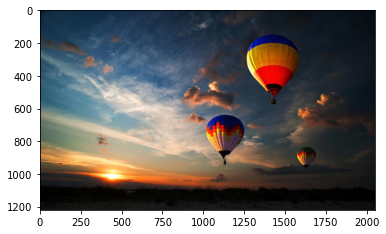

In [69]:
#Running for expanding my own image from 2048*1210 to 2040*1200
img_v_my = MySeamCarving(img_my.copy(), 1220, 2048)
plt.imshow(img_v_my.astype(int))
plt.imsave('img_v_my_expands.jpg', img_v_my)